# 02 - Data Collection with Gamepad
Author: George Gorospe, george.gorospe@nmaia.net (updated 1/14/2023)



## In this second notebook we'll use the gamepad to control our Jetracer while we collect data.

This method is very important and useful because we can use the control input or steering command from the gamepad as our "label" for the data. Together, the image and the steering angle produce a data point we can use to train an AI pilot.



In [4]:
# Importing the required libraries
# IPython Libraries for display and widgets
import traitlets
import ipywidgets
import ipywidgets.widgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from IPython.display import display
from ipyfilechooser import FileChooser
# Style and Layout
from threading import Timer
from uuid import uuid1
import Gamepad
from jetcam.csi_camera import CSICamera


# Style and layout
istyle = {'description_width': 'initial'}
button_layout = Layout( width='350px', height = '36px')

# Instantiate the camera
from jetcam.utils import bgr8_to_jpeg
camera = CSICamera(width=224, height=224)
image = camera.read()
camera.running = True

# Python basic pakcages for image annotation
from uuid import uuid1
import os
import json
import glob
import datetime
import numpy as np
import cv2
import time
from datetime import datetime

# Constants
steering_cmd = 0.21 
throttle_cmd = 0.15
reverse_cmd= 0.25
throttle_reverse_range = 0.05
throttle_forward_range = 0.1

steering_label = 0
throttle_label = 0
steering_bias = -.05 # Center of the image is about 10 pixels from where the steering showes center

# As a default all collected datasets will be stored here
DATASETS_DIR = "/home/racer_core/Datasets/"

# Control library
from jetracer.nvidia_racecar import NvidiaRacecar

# This instance of the NvidiaRacecar() is used to command the car
# Later, we'll use car.steering and car.throttle
car = NvidiaRacecar()

GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3280 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3280 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1640 x 1232 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 59.999999 fps Duration = 16666667 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: Running with following settings:
   Camera index = 0 
   Camera mode  = 4 
   Output Stream W = 1280 H = 7

[ WARN:0@0.936] global cap_gstreamer.cpp:1728 open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


### AI Racer Car Setup

Our JetRacer is a robot, a fast robot. Like any robot there are ways to control our JetRacer.
We have two primary control inputs for our JetRacer:
1. A steering servo signal - used to turn the JetRacer left and right
2. A throttle signal - used to move the JetRacer forward or backwards.

To determine the correct ranges for these signals, we used the calibration notebook to manually adjust the signals.
Now we'll use those ranges for controlling the robot via our gamepad.


In [5]:
####### Reading Racer Parameters - determined from car setup and calibration notebook

file_location = "/home/racer_core/racer_parameters.json"
with open(file_location, 'r') as file_name:
  racer_parameters = json.load(file_name)

#### CAR STEERING PARAMETERS
steering_center = racer_parameters['steering_center']
steering_left_max = racer_parameters['steering_left_max']
steering_right_max = racer_parameters['steering_right_max']

#### CAR THROTTLE PARAMETERS
throttle_forward_start_noise_no_motion = racer_parameters['throttle_forward_start']
throttle_reverse_start_noise_no_motion = racer_parameters['throttle_reverse_start']
dead_throttle = racer_parameters['dead_throttle'] 

### Connecting the Xbox Controller and Receiving Inputs
Next, we'd like to connect the Xbox Controller or gamepad to our computer so that we can take inputs to be used later for steering and throttle.

First, let's make sure our gamepad is connected via bluetooth to the AI Racer's computer.

In [ ]:
# Check connected bluetooth devices: you should see "Xbox Wireless Controller"
!bluetoothctl devices

When the gamepad is connected, we can run the following cell to:
1. Set gamepad settings - map the buttons on the gamepad to variables in the program
2. Initialize gamepad object - load the gamepad software into memory
3. Start background update task - start the task to monitor input from the gamepad, this runs in the background
4. Create callback functions - instructions for what to do when each button is pressed/sticks moved.
5. Link the callback functions to the event handlers - part of the update task responsible for monitoring each button individually.
6. Create the elements of the gamepad graphical user interface and display the interface for testing.

RESULT: Your gamepad input can now be routed into this notebook.

In [7]:
# Gamepad settings
gamepadType = Gamepad.XboxONE
recordButton = 'A'
joystickSpeed = 'RAS -Y'
joystickSteering = 'LAS -X'
pollInterval = 0.05

# Connection Check, and initialize gamepad object
if Gamepad.available():
    print('Gamepad connected')
    gamepad = gamepadType() # Initialize gamepad object
    # Set Initial state
    global running
    running = True
    speed = 0.0
    steering = 0.0
    recording = False
else:
    print('Please connect your gamepad...')
    while not Gamepad.available():
        time.sleep(1.0)

# Start the background updating
gamepad.startBackgroundUpdates()

# Create some callback functions for single events
def recordButtonPressed():
    global recording
    recording = not recording
    if recording == True: 
        buttonStyle_recording()
    else: 
        buttonStyle_default()
    
def speedAxisMoved(position):
    global speed
    gamepad_throttle.value = -position   # Inverted

def steeringAxisMoved(position):
    global steering
    gamepad_steering.value = position # Non-inverted 
    
def buttonStyle_recording():
    recordButton_widget.description = "RECORDING"
    recordButton_widget.button_style = 'danger'

def buttonStyle_default():
    recordButton_widget.description = "waiting"
    recordButton_widget.button_style = ''

# Linking callback functions to event handlers
gamepad.addButtonPressedHandler(recordButton, recordButtonPressed)
gamepad.addAxisMovedHandler(joystickSpeed, speedAxisMoved)
gamepad.addAxisMovedHandler(joystickSteering, steeringAxisMoved)

# Gamepad graphical user interface
gamepad_throttle = widgets.FloatSlider(value=0,min=-1,max=1,step= 0.01,description='Throttle:',disabled=False,continuous_update=True,orientation='vertical',readout=True,readout_format='.2f',)
gamepad_steering = widgets.FloatSlider(value=0,min=-1,max=1.0,step=0.01,description='Steering:',disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f',)
recordButton_widget = widgets.ToggleButton(value=False, description='waiting', disabled=False, button_style='',)
controller_gui = widgets.HBox([gamepad_steering, gamepad_throttle, recordButton_widget])
display(controller_gui)

Gamepad connected


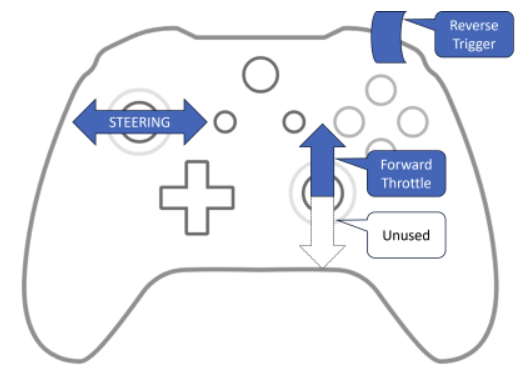

## **** When you run the next cell the gamepad will have full control of the robot, so be careful here! ****

In [8]:
#### Preparing Graphical User Interface for Data Collection with Gamepad

# Required Calculations from Steering Parameters
right_steering_range = abs(steering_right_max - steering_center)
left_steering_range = abs(steering_left_max - steering_center)
steering_range = right_steering_range + left_steering_range
max_steering_range = max([right_steering_range, left_steering_range])


# Required Calculations from Steering Parameters
right_steering_range = abs(steering_right_max - steering_center)
left_steering_range = abs(steering_left_max - steering_center)
steering_range = right_steering_range + left_steering_range
max_steering_range = max([right_steering_range, left_steering_range])

# Setup of Gamepad to Robot graphic user interface (GUI)
# 1. Create the graphic indicators to show gamepad input and commanded output
# 2. Create callback functions and connect them to the controller inputs so they activate when the controller is used
# 3. Create a display for gamepad indicators and output indicators

###### 1. Creating graphic indicators for both the input and output

################ GAMEPAD INDICATORS #####################
# Creating lots of graphical indicators for gamepad input and vehicle command output

# Float Text Box representation of steering input from gamepad
gamepad_steering = widgets.BoundedFloatText(
    value=0, min=-1, max=1.0, step=0.1, description='Steering Input:', disabled=False, style=istyle)

# Slider representation of steering input
gamepad_steering_vis = widgets.FloatSlider(
    value=0, min=-1.0, max=1, step=0.01, description='Steering Output:', disabled=False,
    continuous_update=True, orientation='horizontal', readout=True, readout_format='.2f', style=istyle)

# Text box for steering command to vehicle (DATA LABEL)
data_label_textbox = widgets.BoundedIntText(
    value=0, min=0, max=224, step=0.1, description='Data_Label:', disabled=False)

# Float Text Box representation of throttle command from gamepad
gamepad_throttle = widgets.BoundedFloatText(
    value=0, min=-1, max=1.0, step=0.1, description='Throttle Input:', disabled=False, style=istyle)

# Slider representation of throttle command
gamepad_throttle_vis = widgets.FloatSlider(
    value=0, min=-.5, max=.5, step=0.001, description='Throttle Output:', disabled=False,
    continuous_update=True, orientation='horizontal', readout=True, readout_format='.2f', style=istyle)

# Text box for throttle command to vehicle
throttle_cmd_textbox = widgets.BoundedFloatText(
    value=0, min=-1.0, max=1.0, step=0.1, description='TH_CMD:', disabled=False)

# Float Text Box representation of reverse command from gamepad
gamepad_reverse = widgets.BoundedFloatText(
    value=0, min=0.0, max=1.0, step=0.1, description='Reverse Input:', disabled=False, style=istyle)

# Slider representation of reverse command
gamepad_reverse_vis = widgets.FloatSlider(
    value=0, min=0.0, max=1.0, step=0.01, description='Reverse Output:', disabled=False,
    continuous_update=True, orientation='horizontal', readout=True, readout_format='.2f', style=istyle)

# Text box for reverse command to vehicle
reverse_cmd_textbox = widgets.BoundedFloatText(
    value=0, min=0.0, max=1.0, step=0.1, description='REV_CMD:', disabled=False)

### These two indicators are for the final GUI
# Slider representation of image label
label_vis = widgets.FloatSlider(
    value=0, min=0.0, max=224, step=0.001, description='Label Viz:', disabled=False,
    continuous_update=True, orientation='horizontal', readout=True, readout_format='.2f')
steering_cmd_vis = widgets.BoundedFloatText(
    value=0, min=0.0, max=224.0, step=0.1, description='ST_CMD_Vis', disabled=False)



# Linking widgets: l1 links the controller and the textbox, and l2 links the textbox and slider
# TODO use vehicle parameter constants
#l1 = traitlets.dlink((controller.axes[0], 'value'), (gamepad_steering, 'value'))
l2 = traitlets.dlink((gamepad_steering, 'value'), (gamepad_steering_vis, 'value'), transform=lambda x: -x * max_steering_range + steering_center)

# Connecting the controller output to the label of the data collected
# Controller is [-1, 1], desired label output is [0, 224], lambda function for x is (x+1)*112
d1 = traitlets.dlink((gamepad_steering, 'value'), (data_label_textbox, 'value'), transform=lambda x: (x+1)*112)

#l3 = traitlets.dlink((controller.axes[3], 'value'), (gamepad_throttle, 'value'))
l4 = traitlets.dlink((gamepad_throttle, 'value'), (gamepad_throttle_vis, 'value'), transform=lambda x: x/7 + throttle_forward_start_noise_no_motion)
#ll = traitlets.dlink((gamepad_throttle_vis, 'value'), (throttle_cmd_textbox,'value)'))

#l5 = traitlets.dlink((controller.buttons[7], 'value'), (gamepad_reverse, 'value'))
l6 = traitlets.dlink((gamepad_reverse, 'value'), (gamepad_reverse_vis, 'value'), transform=lambda x: x/20 + throttle_reverse_start_noise_no_motion)

# Creating observers and callback functions to processs the gamepad input values and produce vehcile control commands

# Callback function executes when gamepad's throttle is changed, 'change' is a dictionary containing the 'old' and 'new' values
def throttle_command(change):
    global throttle_cmd
    throttle_cmd = change.owner.value # The new value received from the gamepad (float)
    car.throttle = throttle_cmd
    #vehicle_command(-0.17, throttle_input)

# Callback function executes when gamepad's steering value is changed, 'change' is a dictionary containing the 'old' and 'new' values
def steering_command(change): # (-1.00000, 1.00000)
    global steering_cmd, steering_label
    steering_raw = change.owner.value
    steering_cmd = round(steering_raw,2) # The new value received from the gamepad (float) (-)
    # Consider changing to omit steering_cmd from calculation
    #steering_label_OLD = round(abs((steering_cmd - steering_left_max - steering_bias)/(steering_range+steering_bias)*224))
    #steering_label = round(abs((change.owner.value+1)*112))
    #data_label_textbox.value = steering_label
    car.steering = steering_cmd

# Callback function executes when gamepad's reverse button value is changed, 'change' is a dictionary containing the 'old' and 'new' values
def reverse_command(change):
        global reverse_cmd
        reverse_cmd = round(change.owner.value,2) # The new value received from the gamepad (float)
        car.throttle = reverse_cmd
    # Mapping and command
    #with output: print("Reverse command:" + str(reverse_cmd))
    

# Observers, when values change, they call our callback functions
Obs_1 = gamepad_steering_vis.observe(steering_command, 'value')
obs_2 = gamepad_throttle_vis.observe(throttle_command, 'value')
Obs_3 = gamepad_reverse_vis.observe(reverse_command, 'value')

# Display Elements, show input values and commanded values

steering_display = widgets.HBox([gamepad_steering, gamepad_steering_vis, data_label_textbox])
throttle_display = widgets.HBox([gamepad_throttle, gamepad_throttle_vis])
reverse_display = widgets.HBox([gamepad_reverse, gamepad_reverse_vis])
display(widgets.VBox([steering_display, throttle_display, reverse_display]))

The graphical user interface shows the raw input values from the gamepad. Next to the raw inputs are the mapped values for the output of the computer to the robot chasis. Finally the data label is displayed.

### Select a name for your new dataset

Use the text box to create a name for your new dataset. Try to be descriptive! (No spaces or special characters)
If the folder specified by the user already exists, we'll notify the user.

In this case the name will be representative of the full dataset inside. So if you're collecting data at a school, "school" is a good choice.
Or if you're collecting during daytime, "school_daytime" can be a good, representative folder name.

The folder name is very important in this case because the actual data file names will be automatically generated later, so we want the folder name to be very descriptive. 

NOTE: all new datasets are located at: /home/racer_core/Datasets/

In [9]:
### Creating the graphical user interface for creating our data folder in the data destination folder
# Creating a text box, a button, and connecting the two with a callback function.

# User selected data destination folder:
user_selected_data_destination_folder =  "/home/racer_core/Datasets/"# The path selected earlier
new_directory = "" # for storing the newly created directory where we'll store our data

folder_button = widgets.Button(
    description=' Press to Create New Dataset Folder!',
    button_style= 'success', #, 'info', 'warning', 'danger' or ''
    tooltip='Press to Create Folder!',
    icon='folder-plus', # (FontAwesome names without the `fa-` prefix)
    layout=button_layout,
    style = dict(   font_size='18px', font_weight='bold', font_variant="small-caps"))

folder_label = widgets.Text(value='Enter Name for New Dataset Folder', disabled=False)
author_label = widgets.Text(value='Enter Name of Student Creating Dataset', disabled=False)
description_label = widgets.Text(value='Enter short description of dataset', disabled=False)
label_set_VBox = widgets.VBox([folder_label, author_label, description_label])

# Writes user supplied dataset information to the dataset_log.txt file in the master datasets folder
def write_dataset_log(folder_label, author_label, description_label):
    f = open(DATASETS_DIR + "dataset_log.txt", "a")
    f.write("\n")
    date_time = datetime.now()
    dt_string = date_time.strftime("%m/%d/%Y %H:%M:%S")
    f.write(f"Dataset Record: {dt_string} \n")
    f.write(f"Dataset Name: {folder_label}, Author: {author_label}\n")
    f.write(f"Dataset Description: {description_label}\n")
    f.write("\n")
    f.close()
    

def folder_button_callback(b):
    global new_directory

    new_directory = DATASETS_DIR + folder_label.value + "/"
    dirExist = os.path.exists(new_directory)
    if not dirExist:
        os.makedirs(new_directory)
        folder_button.description = " Folder Created!"
        write_dataset_log(folder_label.value, author_label.value, description_label.value)
        folder_button.disabled = True
    else:
        folder_button.description = " Folder Exists Already!"
        time.sleep(4)
        folder_button.description = " Press to Create New Dataset Folder!"

folder_button.on_click(folder_button_callback)
instructions_01 = widgets.Label(value=str("**** [ACTION REQUIRED] **** Fill in all three boxes then press button."))

Box = widgets.VBox([instructions_01, label_set_VBox,folder_button])
display(Box)

### Setting up the RepeatedTimer:

Next we'll finish camera setup and create a class for a RepeatedTimer object. This object will be useful in repeatedly collecting images as we drive the jetracer.

This class has a self, run, start, and stop functions.

The inputs to this class are: the interval, the function to be repeated, and any inputs to that function

Additionally, we'll create a custom fucntion called, "save_snapshot" that will collect an image with the camera and save it to the new folder.
Since we don't want to manually name each image we collect, we'll use the ``uuid`` package in python, which defines the ``uuid1`` method to generate
a unique identifier.  This unique identifier is generated from information like the current time and the machine address. 

We go through this complicated process so that we never create two files with the same name.

In [10]:
# Camera setup
image = ipywidgets.Image(format='jpeg', width=camera.width, height=camera.height)
labeled_image = widgets.Image(format='jpeg', width=224, height=224)  # this width and height doesn't necessarily have to match the camera
camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)

########## DATA COLLECTION INTERVAL #################
# Adjust this variable if you would like to collect data at a slower rate
interval = 0.1

### CUSTOM CLASS: RepeatedTimer - we create a custom class so that we can genreate a RepeatedTimer object to perform automated data collection
class RepeatedTimer(object):
    def __init__(self, interval, function, set_size, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.index      = 0
        self.set_size   = set_size
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        # While running, check against desired set_size, stop when set size is reached
        self.index = self.index + 1
        if self.index <= self.set_size:
            self.is_running = False
            self.start()
            self.function(*self.args, **self.kwargs)
        else:
            #self._time.cancel()
            self.is_running = False
            
    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False
###### END OF CUSTOM CLASS ############

#### User Defined Function: save_snapshot: collects an image and saves the image when called ####
###       Extra: This function uses the current position of the gamepad steering stick to automatically add a label to the image
###       Extra pt. 2: This function stores the label within the name of the new file as it saves it with a unique name and number.
def save_snapshot():
    global image_count
    index = image_count.value = len(os.listdir(new_directory))
    
    # Our new labels come from the vehicle command values at the time the information was collected
    # This includes the steering position
    # Steering will be converted from the steering range to position in the image so we can visualize steering input.
    steering_bias = 0 # Center of the image is about 10 pixels from where the steering showes center
    
    steering_label = data_label_textbox.value

    # Create a new filename with the coordinates appended, then save the file in the new directory.
    uuid = '%03d_%03d_%04d_%s' % (steering_label, throttle_label,index, uuid1()) #uuid(1) creates a unique string each time it's called
    image_path = os.path.join(new_directory, uuid + '.jpg') # Building the path & filename for the new labeled data point
    label_vis.value = steering_label
    with open(image_path, 'wb') as f:
        f.write(image.value) # camera.value for csi camera, image.value for jetcam

So far we have:
- [x] Setup the car() object for steering and throttle control
- [x] Connected and tested the gamepad
- [x] Created Callback functions to connect the gamepad with vehicle control
- [x] Created a new folder to hold our new dataset
- [x] Created an interval timer and save_snapshot function to automate data collection w/ labels!
d.

Next we'll start the data collection. As we manually drive our AI racer, we're creating the data that we'll use to train our racer's AI pilot.
1. The data should depict excellent driving. So when collecting data, it is critically important to drive perfectly!
2. We need lots of data! 20,000 data points is a good goal to reach for!

The next cell finishes the camera setup and user interface.

In [11]:
# Button creation and widget layout
button_layout = widgets.Layout(width='128px', height='64px')
# Buttons to controll data collection
start_button = widgets.Button(description='Start Collection', button_style='success', layout=button_layout)
stop_button = widgets.Button(description='Stop Collection', button_style='danger', layout=button_layout)
# image_count is used to display the number of images in the folder
image_count = widgets.IntText(layout=button_layout,continuous_update=True, value=len(os.listdir(new_directory)))


    
# attach the callbacks, we use a 'lambda' function to ignore the
# parameter that the on_click event would provide to our function
# because we don't need it.
start_button.on_click(lambda x: rt.start())
stop_button.on_click(lambda x: rt.stop())

# Testing set_size collection
set_size = 10000
# Setup of the repeated timer to handle data collection
rt = RepeatedTimer(interval, save_snapshot,set_size) # it auto-starts, no need of rt.start()
rt.stop()

# User Interface
top_half_display = widgets.HBox([image, labeled_image])
display(image)
display(label_vis)
display(widgets.HBox([image_count, start_button, stop_button]))

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

FloatSlider(value=0.0, description='Label Viz:', max=224.0, step=0.001)